   # Project = E-COMMERCE Analytics


In [1]:
# Importing required libraries

import pandas as pd                                      # Read the file ,check the null values
import matplotlib.pyplot as plt                          # To plot the graphs
import seaborn as sns                                    # To plot the graph
import numpy as np                                       # Use for calculation 
from sklearn.preprocessing import LabelEncoder           # To build the KMeans Model
from mlxtend.frequent_patterns import apriori            # For Market Basket Analysis
from mlxtend.frequent_patterns import association_rules  # For rule formation

In [2]:
# Import e-commerce transaction file of almost 13 months i.e. from date Dec 2016 to Dec 2017
# Read the file and get overview of data from top
# To read the string correctly r is used as the prefix on this command 
# low_memory = False, then whole columns will be read in first, and then the proper types determined

eca=pd.read_csv(r"D:\Notes\Data Science\Imarticus\Data Files\Project -1. Ecommerce Analytics\E-com_Data.csv",
                low_memory= False)

In [3]:
# Viewing top 5 data

eca.head()

,CustomerID,Item Code,InvoiceNo,Date of purchase,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return,Sold as set
0,4355.0,15734,398177,29/10/2017,6,3:36:00 PM,321.0,1926.0,Location 1,NaN,NaN,NaN
1,4352.0,14616,394422,05/10/2017,2,2:53:00 PM,870.0,1740.0,Location 1,NaN,NaN,NaN
2,4352.0,14614,394422,12/10/2017,2,2:53:00 PM,933.0,1866.0,Location 1,NaN,NaN,NaN
3,4352.0,85014B,388633,22/08/2017,3,2:47:00 PM,623.0,1869.0,Location 1,NaN,NaN,NaN
4,4352.0,15364,394422,10/10/2017,2,2:53:00 PM,944.0,1888.0,Location 1,NaN,NaN,NaN


In [4]:
# It will show all column names

eca.columns

Index(['CustomerID', 'Item Code', 'InvoiceNo', 'Date of purchase', 'Quantity',
       'Time', 'price per Unit', 'Price', 'Shipping Location',
       'Cancelled_status', 'Reason of return', 'Sold as set'],
      dtype='object')

# Data Cleaning

In [5]:
# Drop unwanted columns

eca = eca.drop(['Cancelled_status', 'Reason of return', 'Sold as set'], axis = 1)

In [6]:
# Rename the required columns, because some column names have space in between them
# In python having space in column name didn't work so we need to remove the space

eca.rename(columns = {"Item Code": "Item_Code" ,
                      "Date of purchase":"Date_of_purchase",
                      "price per Unit":"price_per_Unit",
                      "Shipping Location":"Shipping_Location"},
           inplace = True)

In [7]:
# After some changes in the file, again overview the data
# Whether the columns has been dropped and column names should be changed or not

eca.head()

,CustomerID,Item_Code,InvoiceNo,Date_of_purchase,Quantity,Time,price_per_Unit,Price,Shipping_Location
0,4355.0,15734,398177,29/10/2017,6,3:36:00 PM,321.0,1926.0,Location 1
1,4352.0,14616,394422,05/10/2017,2,2:53:00 PM,870.0,1740.0,Location 1
2,4352.0,14614,394422,12/10/2017,2,2:53:00 PM,933.0,1866.0,Location 1
3,4352.0,85014B,388633,22/08/2017,3,2:47:00 PM,623.0,1869.0,Location 1
4,4352.0,15364,394422,10/10/2017,2,2:53:00 PM,944.0,1888.0,Location 1


In [8]:
# Check the total number of null values in columnswise

eca.isnull().sum()

CustomerID           133790
Item_Code                 0
InvoiceNo                 0
Date_of_purchase          0
Quantity                  0
Time                      0
price_per_Unit            0
Price                     0
Shipping_Location         0
dtype: int64

In [9]:
# Fill all null values with same new int value

eca.CustomerID = eca.CustomerID.fillna(eca.CustomerID.max() + 1)

In [10]:
# Again check whether null values replaced or not

eca.isnull().sum()

CustomerID           0
Item_Code            0
InvoiceNo            0
Date_of_purchase     0
Quantity             0
Time                 0
price_per_Unit       0
Price                0
Shipping_Location    0
dtype: int64

In [11]:
# Create object and convert non numeric values to numeric values

le = LabelEncoder()
eca.Date_of_purchase = le.fit_transform(eca.Date_of_purchase)
eca.InvoiceNo = le.fit_transform(eca.InvoiceNo)

In [12]:
# Find the latest date for Recency formula

latest_date = eca.Date_of_purchase.max() + 1

# RFM Model Building

In [13]:
# RECENCY = Latest Date - Date of Purchase
# FREQUENCY = Count of Invoice No. for individual Customer ID
# MONETARY = Sum of Total Purchase Price of individual Customer ID
# Group all the transactions using CustomerID

RFM = eca.groupby("CustomerID").agg({"Date_of_purchase": lambda x:(latest_date - x.max()),
                                     "InvoiceNo" : lambda x:len(x),
                                     "Price" : lambda x:x.sum()})

In [14]:
# Rename the columns for better understanding

RFM.rename(columns = {"Date_of_purchase": "RECENCY" ,
                           "InvoiceNo":"FREQUENCY",
                           "Price":"MONETARY"}, inplace = True)

In [15]:
# Remove those values from Monetary whose sum is less than "0", because taking log of negative values making our data more skewed

RFM = RFM[(RFM["MONETARY"]> 0)]

In [16]:
# Assigning the index value to each records

RFM.reset_index().head(1000)

,CustomerID,RECENCY,FREQUENCY,MONETARY
0,2.0,7,182,553704.0
1,3.0,7,27,257404.0
2,4.0,9,72,176613.0
3,5.0,240,16,41976.0
4,6.0,6,84,151822.0
...,...,...,...,...
995,1009.0,170,14,32972.0
996,1010.0,32,197,343530.0
997,1011.0,41,1,10050.0
998,1012.0,2,135,300960.0


In [17]:
# Split into 4 segment using Quantiles

Quantiles = RFM.quantile(q= [0.25,0.50,0.75])
Quantiles = Quantiles.to_dict()
Quantiles 

{'RECENCY': {0.25: 6.0, 0.5: 17.0, 0.75: 91.0},
 'FREQUENCY': {0.25: 18.0, 0.5: 42.0, 0.75: 102.0},
 'MONETARY': {0.25: 38594.5, 0.5: 84982.0, 0.75: 206963.0}}

In [18]:
# Function to create R,F & M segments.(Segmentation)
# Assign value 1 for highest value of Recency

def Rscoring(a,b,c):
    if a <= c[b][0.25]:
        return 4
    elif a <= c[b][0.50]:
        return 3
    elif a <= c[b][0.75]:
        return 2
    else :
        return 1

# Assign value 1 for the lowest value of Frequency and Monetary

def FMscoring(a,b,c):
    if a <= c[b][0.25]:
        return 1
    elif a <= c[b][0.50]:
        return 2
    elif a <= c[b][0.75]:
        return 3
    else :
        return 4

In [19]:
# Calculate and add new columns of R, F and M values

RFM["R"] = RFM["RECENCY"].apply(Rscoring, args = ("RECENCY", Quantiles ,))
RFM["F"] = RFM["FREQUENCY"].apply(FMscoring, args = ("FREQUENCY", Quantiles ,))
RFM["M"] = RFM["MONETARY"].apply(FMscoring, args = ("MONETARY", Quantiles ,))
RFM.head()

,RECENCY,FREQUENCY,MONETARY,R,F,M
CustomerID,,,,,,
2.0,7,182,553704.0,3,4,4
3.0,7,27,257404.0,3,2,4
4.0,9,72,176613.0,3,3,3
5.0,240,16,41976.0,1,1,2
6.0,6,84,151822.0,4,3,3


In [20]:
# Calculate & add RFM score value column, which is showing total sum of RFM values
# RFMScore gives the score for customers loyalty ,the higher the value more loyal is the customer.

RFM["RFMScore"] = RFM[["R","F","M"]].sum(axis=1)
RFM.head()

,RECENCY,FREQUENCY,MONETARY,R,F,M,RFMScore
CustomerID,,,,,,,
2.0,7,182,553704.0,3,4,4,11
3.0,7,27,257404.0,3,2,4,9
4.0,9,72,176613.0,3,3,3,9
5.0,240,16,41976.0,1,1,2,4
6.0,6,84,151822.0,4,3,3,10


In [21]:
# Assign loyalty level to each customers based on RFM Score
# Bronze = is the customer who has not purchased from long time
# Platinum = most loyal customer, we don't want to loose this customer

loyalty_levels = ["Bronze", "Silver", "Gold", "Platinum"]
score_cut = pd.qcut(RFM.RFMScore, q= 4, labels = loyalty_levels)
RFM["loyalty_level"] = score_cut.values

RFM.reset_index().head()

,CustomerID,RECENCY,FREQUENCY,MONETARY,R,F,M,RFMScore,loyalty_level
0,2.0,7,182,553704.0,3,4,4,11,Platinum
1,3.0,7,27,257404.0,3,2,4,9,Gold
2,4.0,9,72,176613.0,3,3,3,9,Gold
3,5.0,240,16,41976.0,1,1,2,4,Bronze
4,6.0,6,84,151822.0,4,3,3,10,Gold


C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


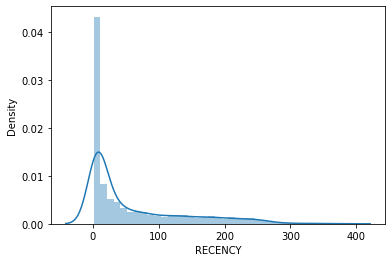

In [22]:
# Recency distribution plot

R = RFM["RECENCY"]
AR = sns.distplot(R)    #Right skewed 

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


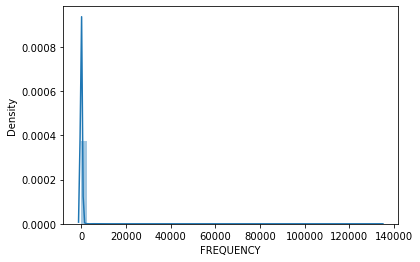

In [23]:
# Frequency distribution plot

F = RFM["FREQUENCY"]
AF = sns.distplot(F)   #Right skewed 

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


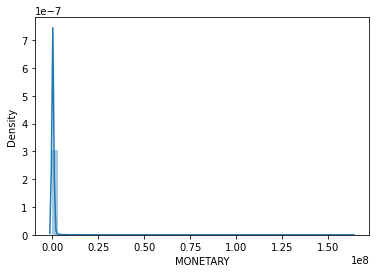

In [24]:
# Monetary distribution plot

M = RFM["MONETARY"]
AM = sns.distplot(M)    #Right skewed

In [25]:
# As data is right skewed, we need to normalize it by using log transformation method 

RFM_log_Tfd = RFM[["RECENCY","FREQUENCY","MONETARY"]].apply(np.log, axis = 1).round(3)
RFM_log_Tfd.head(100)

,RECENCY,FREQUENCY,MONETARY
CustomerID,,,
2.0,1.946,5.204,13.224
3.0,1.946,3.296,12.458
4.0,2.197,4.277,12.082
5.0,5.481,2.773,10.645
6.0,1.792,4.431,11.930
...,...,...,...
97.0,2.708,4.419,11.986
98.0,2.485,3.091,11.509
99.0,2.197,3.892,11.380


C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


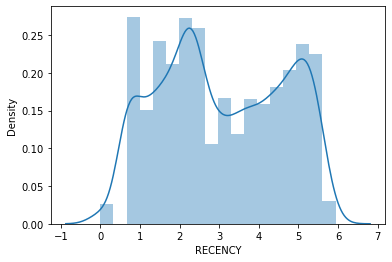

In [26]:
# Data distribution after data normalization

Recency_Plot = RFM_log_Tfd['RECENCY']
ax = sns.distplot(Recency_Plot)

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


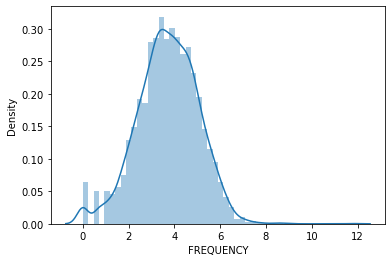

In [27]:
# Data distribution after data normalization

Frequency_Plot = RFM_log_Tfd['FREQUENCY']
ax = sns.distplot(Frequency_Plot)

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


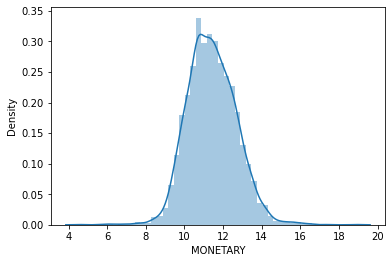

In [28]:
# Data distribution after data normalization

Monetory_Plot = RFM_log_Tfd['MONETARY']
ax = sns.distplot(Monetory_Plot)

In [29]:
# Bring the data on same scale

from sklearn.preprocessing import StandardScaler

# Create Object

ss = StandardScaler()

RFM_Scaled_Data = ss.fit_transform(RFM_log_Tfd)

RFM_Scaled_Data = pd.DataFrame(RFM_Scaled_Data, index = RFM.index, columns= RFM_log_Tfd.columns)

RFM_Scaled_Data.head()

,RECENCY,FREQUENCY,MONETARY
CustomerID,,,
2.0,-0.714114,1.130944,1.436536
3.0,-0.714114,-0.310994,0.828145
4.0,-0.552674,0.430379,0.529509
5.0,1.559558,-0.706243,-0.611820
6.0,-0.813165,0.546762,0.408784


# K- Means Model Building

In [30]:
# To find the value of k we are using Elbow method.

from sklearn.cluster import KMeans

empty_dist = {}
for i in range(1,20):
    kmeans = KMeans(n_clusters = i)
    kmeans = kmeans.fit(RFM_Scaled_Data)
    empty_dist[i] = kmeans.inertia_

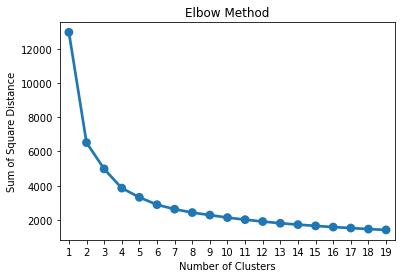

In [31]:
# Plot the graph of Number of clusters against Sum square distance to find the k value

sns.pointplot(x = list(empty_dist.keys()), y = list(empty_dist.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Square Distance')
plt.title('Elbow Method');

In [32]:
# Build K-means model

RFM_kmeans = KMeans(n_clusters = 3)
RFM_kmeans.fit(RFM_Scaled_Data)

RFM['Cluster'] = RFM_kmeans.labels_
RFM.head()

,RECENCY,FREQUENCY,MONETARY,R,F,M,RFMScore,loyalty_level,Cluster
CustomerID,,,,,,,,,
2.0,7,182,553704.0,3,4,4,11,Platinum,2
3.0,7,27,257404.0,3,2,4,9,Gold,0
4.0,9,72,176613.0,3,3,3,9,Gold,0
5.0,240,16,41976.0,1,1,2,4,Bronze,1
6.0,6,84,151822.0,4,3,3,10,Gold,0


# Market Basket Analysis

In [33]:
# Create Itemsets that are purchased together on the basis of Invoice No

market_basket = eca.groupby(['InvoiceNo', 'Item_Code'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [34]:
# Viewing data

market_basket.head()

Item_Code,10123C,10123G,10124A,10124G,10430,13038,13039,13040,13041,13042,...,9461,9519,9597,C2,DCGS0055,DCGS0057,DCGS0066P,DCGS0067,Discount,TRANSP
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Converting all positive values to 1 and rest of the values to 0

def handle_neg(fun1):
    if fun1 <= 0:
        return 0
    else:
        return 1

my_basket = market_basket.applymap(handle_neg)

# Training Model

In [36]:
# Generating frequent itemsets

my_frequent_itemsets = apriori(my_basket, min_support= 0.03, use_colnames= True)

In [37]:
# Generating rules

rules = association_rules(my_frequent_itemsets, metric= "lift", min_threshold= 1)

In [38]:
# Viewing top 100 rules

rules.head(100)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(85099B),(14809),0.083681,0.048780,0.032975,0.394056,8.078140,0.028893,1.569813
1,(14809),(85099B),0.048780,0.083681,0.032975,0.675987,8.078140,0.028893,2.828030
2,(15122),(15120),0.042683,0.040717,0.030769,0.720865,17.704152,0.029031,3.436622
3,(15120),(15122),0.040717,0.042683,0.030769,0.755665,17.704152,0.029031,3.918052


# Making recommendations

In [39]:
# Filtering rules based on condition

rules[(rules['lift']>=5) & (rules['confidence']>=0.5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(14809),(85099B),0.048780,0.083681,0.032975,0.675987,8.078140,0.028893,2.828030
2,(15122),(15120),0.042683,0.040717,0.030769,0.720865,17.704152,0.029031,3.436622
3,(15120),(15122),0.040717,0.042683,0.030769,0.755665,17.704152,0.029031,3.918052
